In [2]:
%matplotlib inline
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy import signal
import peakutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, datetime
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

In [5]:
char_inps = pd.read_csv("LABELED_CHARACTER_INPUTS.csv", index_col=0)

In [6]:
char_inps.head()

,index,peak time,signal,start time,end time,char,is_space,peak_diff,0,1,...,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800
0,0,2.438667,21817.500000,2.403667,2.753667,a,0,0.256667,0,-2,...,-3,-7,19,32,21,6,-3,16,39,30
1,1,2.695333,1512.641846,2.660333,3.010333,l,0,0.303333,-21,-18,...,-293,-626,-223,-143,-477,-192,-210,-841,-547,NaN
2,2,2.998667,2700.784424,2.963667,3.313667,i,0,0.238000,-7,-11,...,24,14,-11,-6,-14,-35,-19,-2,-12,-9
3,3,3.236667,11063.173828,3.201667,3.551667,c,0,0.326667,-19,-18,...,0,-6,3,8,0,0,-1,-23,-36,-25
4,4,3.563333,37448.300781,3.528333,3.878333,e,0,0.284667,14,-19,...,21,16,1,113,150,-68,-219,-158,-145,-107


In [10]:
char_inps[char_inps.columns[8:]].values.shape

(1052, 16801)

In [49]:
# Takes in sequential order of numpy arrays representing window for keypress 
# Outputs (keypress x 80) numpy array with cepstrum applied to it
def extract_cepstrum(keypress_sigs, rate, mfcc_start=2, mfcc_end=9):
    keypress_feats = []
    for keypress_sig in keypress_sigs:
        mfcc_feat = mfcc(keypress_sig, rate, winlen=0.04, 
        winstep=0.025, numcep=16, nfilt=32, 
        lowfreq=400, highfreq=12000)
        keypress_feats.append(np.concatenate(mfcc_feat[:, :]).T)
    data = np.vstack(keypress_feats)
    return data

In [83]:
targ_s = "".join([" " if c == '#SPACE' else c for c in list(char_inps['char'].values)[:-1]])
mike_char_data = char_inps[char_inps.columns[8:]].values
mike_keypress_data = np.split(mike_char_data, 1052, axis=0)
mike_keypress_data = [np.squeeze(l) for l in mike_keypress_data]
data = extract_cepstrum(mike_keypress_data, rate, mfcc_start=0, mfcc_end=19)

In [81]:
num_clusters = 50
data = whiten(data)
pca = PCA(n_components=100)
pca.fit(data)
data = pca.transform(data)
kmeans = KMeans(n_clusters=num_clusters, n_init=200).fit(data)
labels = kmeans.labels_[:-1]
np.set_printoptions(threshold=10)



labels_count = np.zeros((27, num_clusters))
for pred_label, c in zip(labels, targ_s):
    ind = ord(c) - 97
    if ind < 0:
        ind = 26
    labels_count[ind][pred_label] += 1
spaces_vec = labels_count[-1]

In [79]:
spaces_vec.shape

(50,)

In [105]:
hmm, logprob, pred, data, labels, pca = run_hmm(data, targ_s)

-4160.11060029 [ 5  6  1 ...,  3  0 14]
-4192.50590334 [ 5 19 26 ..., 18  6 24]
-4156.87370329 [ 5  0  5 ..., 14 26  2]
-4155.0810759 [ 5 20  0 ..., 18 26  2]
-4202.10431306 [ 5  1  1 ...,  9  3 12]


In [106]:
print np.exp(logprob/(len(pred)))

pred_str = transform_to_str(pred)
pred_set = set(pred_str.split())
targ_set = set(targ_s.split())
sim = targ_set.intersection(pred_set)
print len(sim)

pred_str = transform_to_str(pred)
print pred_str

0.0184185727505
10
fbbsofwhe adshey as oumpid rdcryvgxqdatherwhabvxxmast d ayxyqkqnkf bxdtubuwngxin pavexr hjyjxkmaloon asin invcxlo waindinsocofthar athafthblaradins he uithetoo alsticenvbuk pinyur wouicer her the ocqyvhll thethangeurs alicrvtervcoutis p otlyqqurvkxandlxfynshg thjvmlxwopvdbllin halicy pvale t whe wincourulingsithe the wsinkaleheingo hery hingonind xve it pverheinslvms her singict d invy wng pycqrke ngqvlcomatokvedor and tuver smk whermfnthaqngggjvice act st it oofqtoxingstubboflingsbqvckrklmsist bfwhermvxy t asheatavyet ce of hemerasxqin wppxxcony vxthxjwnokconggentulk t alosingsit to ate bicer whmed ingee okpjqt bengxdinlle ace bvedug anvmhonokitowaqqugvjjjmhxmedpincmwag t as h be abmljjqver actsisa ich ad satoxatherit akme ad slxs s san arxkjatokstyheraingchmuin brntidlis tickarepver byxharawouthoonofqxxbve cor th t wt made atuinxathaathaiernd thers ngvthon ono sinkxicxdither asud aid waithonkbin s vr astour o ald tordegmasncoean bxhe wak ate te idiste inghe ceve ak

In [97]:
hmm.emissionprob_.shape

(27, 50)

In [116]:
im = Image.fromarray(hmm.emissionprob_ * 100)
im.show()

In [109]:
from matplotlib.pyplot import imshow 

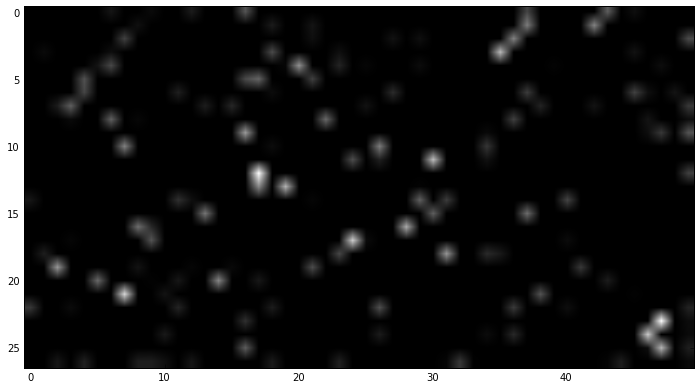

In [115]:
fig = plt.figure(figsize=(12, 12))
imshow(hmm.emissionprob_, cmap="gray")

In [59]:
print targ_s

alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the w

In [55]:
labels_count = np.zeros((27, num_clusters))
for pred_label, c in zip(labels, targ_s):
    ind = ord(c) - 97
    if ind < 0:
        ind = 26
    labels_count[ind][pred_label] += 1

In [56]:
np.set_printoptions(threshold=10)

In [117]:
from PIL import Image
im = Image.fromarray(labels_count * 10)
im.show("clusters")

In [58]:
np.set_printoptions(threshold=np.inf)
print labels_count
np.set_printoptions(threshold=10)

[[  0.   0.   0.   0.   1.   5.   0.   0.   1.  13.   1.   2.   1.   0.
    1.   0.   0.   1.   0.   0.   2.   0.   1.  18.   0.   0.   0.   0.
    0.   1.   1.   0.   1.   1.   0.   0.   1.   1.   0.   3.   0.   0.
    0.   0.   8.   2.   0.   0.   0.   0.]
 [  0.   2.   0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   3.   0.
    0.   0.   0.   3.   0.   1.   0.   2.   0.   1.   0.   0.   0.   0.
    0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   4.   0.
    0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   5.   0.   0.   0.   2.   0.   0.   0.   0.
    1.   1.   0.   1.   0.   0.   6.   1.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   3.   1.   1.   0.   0.   0.   0.]
 [  2.   0.   0.   0.   2.   4.   0.   3.   0.   1.   1.   4.   5.   0.
    0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   1.
    0.   1.   0.   0.   5.   0.   1.   0.   0.   0.   0.   0.   0.   0.
    0. 

In [ ]:
emiss_m = np.random.rand(27, num_clusters)
space_vec = np.zeros((num_clusters)) + space_smooth

In [87]:
for i in range(1):
    print 'wtf'

wtf


In [104]:
wave_len = 0.04
shift_start_back = 2

# Takes in sequential order of numpy arrays representing window for keypress 
# Outputs (keypress x 80) numpy array with cepstrum applied to it
def extract_cepstrum(keypress_sigs, rate, mfcc_start=2, mfcc_end=9):
    keypress_feats = []
    for keypress_sig in keypress_sigs:
        mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
        winstep=0.0025, numcep=16, nfilt=32, 
        lowfreq=400, highfreq=12000)
        keypress_feats.append(np.concatenate(mfcc_feat[mfcc_start:mfcc_end, :]).T)
    data = np.vstack(keypress_feats)
    return data

def run_hmm(data, targ_s, n_init=5, whiten_data=True, num_clusters=50, space_smooth=0, trans_smooth=2):
    if whiten_data:
        data = whiten(data)
        
    pca = PCA(n_components=100)
    pca.fit(data)
    data = pca.transform(data)
    
    kmeans = KMeans(n_clusters=num_clusters, n_init=200).fit(data)
    
    # Get labels from running clustering
    labels = kmeans.labels_.reshape(-1, 1)
    
    labels_count = np.zeros((27, num_clusters))
    for pred_label, c in zip(labels, targ_s):
        ind = ord(c) - 97
        if ind < 0:
            ind = 26
        labels_count[ind][pred_label] += 1
    space_vec = labels_count[-1]
    
    # Init spaces to reasonable values
    #space_inds = [i for i, letter in enumerate(targ_s) if letter == " "][:10]
    #space_inds = np.array(spaces)
    #spaces = kmeans.labels_[space_inds]

    # Build transition matrix
    trans_m = np.zeros((27, 27)) + trans_smooth
    for i in range(len(targ_s)-1):
        c, next_c = ord(targ_s[i]) - 97, ord(targ_s[i+1]) - 97
        if c < 0:
            c = 26
        if next_c < 0:
            next_c = 26
        trans_m[c][next_c] += 1
    row_sums = trans_m.sum(axis=1)
    trans_m = trans_m / row_sums[:, np.newaxis]

    # Build emission matrix
    emiss_m = np.random.rand(27, num_clusters)
#     space_vec = np.zeros((num_clusters)) + space_smooth
#     for i in spaces:
#         space_vec[i] += 1
    emiss_m[26, :] = space_vec
    row_sums = emiss_m.sum(axis=1)
    emiss_m = emiss_m / row_sums[:, np.newaxis]

    # Create HMM
    hmm = MultinomialHMM(n_components=27, verbose=False, init_params="e", params="se", tol=1e-6, n_iter=10000) 
    
    min_logprob = 0
    for i in range(n_init):
        hmm.n_features = num_clusters
        hmm.transmat_ = trans_m
        hmm.emissionprob_ = emiss_m
    
        # Fit and decode
        hmm = hmm.fit(labels)
        logprob, pred = hmm.decode(labels, algorithm='viterbi')
        print logprob, pred
    
        if logprob < min_logprob:
            min_logprob = logprob
            min_hmm = deepcopy(hmm)
            min_pred = pred
    
    return hmm, logprob, pred, data, labels, pca

def transform_to_str(pred):
    s = ''
    for i in pred:
        if i == 26:
            s += ' '
        else:
            s += chr(97 + i)
    return s

(rate,sig) = wav.read("alice_space_slow.wav")
sig = sig[:, 1]

# t -> X, time
# f -> Y, frequency in HZ
# Sxx -> C, actual values themselves
f, t, Sxx = signal.spectrogram(sig, rate)

targ_s = "alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the world she was going to get out again the rabbit hole"
sig_str = np.sum(Sxx[2:71, :], axis=0)

# According to paper, usually around 100ms left between 
# conseuctive keystrokes so min_dist should be around 20
# Difference between adjacent signals is 5ms
indexes = peakutils.indexes(sig_str, thres=0.0007, min_dist=30)
len(indexes), len(targ_s)

# Maybe just do some parameter tuning, try to maximize number of unique words found in set
# Find and extract all parameters that can be taken out
# Try to use dataframes
keypress_sigs = []

# fig = plt.figure(figsize=(18, 18))
# plt.plot(t, sig_str)
# plt.plot(t[indexes], sig_str[indexes], 'o')

spaces = [5, 19, 26, 32, 49, 56, 63, 70, 75, 79, 86, 94, 99, 104, 113, 117, \
          120, 126, 132, 136, 141, 145, 151, 156, 163, 167, 170, 175, 178, 186, 190]

for i in range(len(indexes)):
    ind = indexes[i]
    # Take exactly 40 ms
    # if i in spaces:
        # plt.plot(t[ind - 2: ind + 6], sig_str[ind - 2: ind + 6], 'r')
    key_start = int(t[ind - shift_start_back] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sigs.append(sig[key_start:key_end]) 
    
data = extract_cepstrum(keypress_sigs, rate)
# plt.ylim(0, 1.5e-5)
# plt.xlim(0, 130)
# plt.show()

-4351.63050263 [10  0 13 ...,  8 16 22]
0.0159781854558
11
kangy thepxqkingh btoiccobkiqxsivxwaqr adt wan bingfpgqur t afure anojpthpvwheerxjder bor ge ino alliczvlpxwaxlljasuitheryvnd pn her alitwave pqxrkkyqupvyjct oheleme ot otfkjqrictwhowxvered t heghafk ascedlvceng he tok theraver verygzfjthelitorin outherbind afce inishy ingvlermuccofet ind o the dver thallithkxxugfpicmedfpfong sqwithe txqaitheredqthe ak biczveeericfwzkjitkqvrxoxbubbulxid ryerbaf he thalininde wasqs torqhesit id whengst t healyyycepiczde ad aomder o ocowouisnge ceryongahe falk aliuqfngin wipik thqe dingpqxcjjsingly ithjxwixjj tholoualliclery s wxher iche wd sufwofouqp hepsing sit it budbbqgkuthin wiclycherllupquthhokqpiour wnowhag hedisthang whonondft pinkin out haveryngesinve os wofthevbuthredpk o ldiorpd bozvbgullzzjujuthd afug woomd aldd ouind that moqljqpver o s w sha t ato s bouynxbungy pbyous ofery hlokjbd wan s woo d thinkgpisijqwkathxlkknofvers xxbbe psthingqcenkuryvmoupfqurscoathxzpng bicofbxpnsjcxwndr i

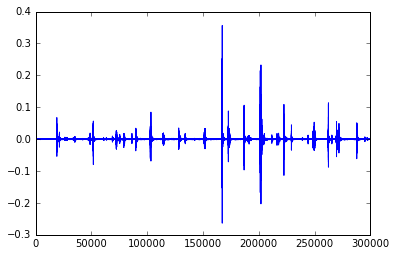

In [72]:
pd.Series(sig[500000:800000]).plot()

In [86]:
# If word is reasonably close to an English word, correct spelling
# Add the indices of this new word to a training set
# Use an RNN or something to train on it
# Apply spelling corrections again, etc.

14
